# Notebook to go step by step in the selection/reduction/calibration of DL0 data to DL1
<font size="4">
**Content:**
- Data loading
- Calibration:
    - Pedestal substraction
    - Peak integration
    - Conversion of digital counts to photoelectrons.
    - High gain/low gain combination
- Cleaning
- Hillas parameters
- Disp reconstruction (from Hillas pars)
- TEST: High gain/Low gain 
- Using of Pyhessio to access more MC information:
    - Simulated phe, number of simulated events, simulated energy range, etc.
    - Calculation of the spectral weight for one event.
- TEST: Comparison of Hillas intensity with simulated number of phe.
- Spectral weighting for a set of events.

### Some imports...

In [1]:
from ctapipe.utils import get_dataset_path
from ctapipe.io import event_source
from ctapipe.io.eventseeker import EventSeeker
import astropy.units as u
from copy import deepcopy

from lstchain.calib import lst_calibration
from ctapipe.image import hillas_parameters

import pyhessio
import lstchain.reco.utils as utils
from lstchain.reco import r0_to_dl1
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/Users/rubenlopez/anaconda/envs/cta-dev/lib/python3.6/site-packages/corsikaio/subblocks/dtypes.py:20: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dict(**dt))
/Users/rubenlopez/anaconda/envs/cta-dev/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Data loading

Get the origin file with dl0 data which is a simtelarray file

In [2]:
#input_filename=get_dataset_path('gamma_test_large.simtel.gz')
input_filename="/home/queenmab/DATA/LST1/Gamma/gamma_20deg_0deg_run8___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz"

Get the data events into a ctapipe event container. We are only interested in LST1 events

In [3]:
pyhessio.close_file()
tel_id = 1
allowed_tels = {tel_id}
source = event_source(input_filename)
source.allowed_tels = allowed_tels

In [4]:
## Load the first event
#event = next(iter(source))


## OR select an event manually
seeker = EventSeeker(source)
event = seeker[4]

# OR Find an event that saturates the high gain waveform
'''
counter = 0
howmany = 4
for event in source:
        if np.any(event.r0.tel[1].waveform > 4094):
            bright_event = deepcopy(event)
            tel_id = tid
            counter = counter + 1
            if counter > howmany:
                break
event = bright_event
'''
## OR find a bright LST event:
# intensity = 0
# for event in source:
#     for tid in event.r0.tels_with_data:
#         if event.r0.tel[tid].image.sum() > intensity and tid in np.arange(8):
#             intensity = event.r0.tel[tid].image.sum()
#             bright_event = deepcopy(event)
#             tel_id = tid
# event = bright_event

'\ncounter = 0\nhowmany = 4\nfor event in source:\n        if np.any(event.r0.tel[1].waveform > 4094):\n            bright_event = deepcopy(event)\n            tel_id = tid\n            counter = counter + 1\n            if counter > howmany:\n                break\nevent = bright_event\n'

Take a look at the event container. Select any event using the event seeker

In [5]:
event.r0.tel[1]

ctapipe.io.containers.R0CameraContainer:
                  trigger_time: Telescope trigger time, start of waveform
                                readout, None for MCs
                  trigger_type: camera's event trigger type if applicable
                  num_trig_pix: Number of trigger groups (sectors) listed
                   trig_pix_id: pixels involved in the camera trigger
                         image: numpy array containing integrated ADC data
                                (n_channels x n_pixels) DEPRECATED
                      waveform: numpy array containing ADC samples(n_channels x
                                n_pixels, n_samples)
                   num_samples: number of time samples for telescope

In [6]:
EvID = event.r0.event_id
print(EvID)

26107


Get the waveform data

In [7]:
data = event.r0.tel[tel_id].waveform
data.shape

(2, 1855, 30)

The waveform is a matrix, has 30 samples in each of the 1855 pixels, for 2 gains. 

### We can plot the waveforms and have an idea of their shapes.

Lame loop to find a pixel with signal: 

In [8]:
maxvalue=0
for pixel in enumerate(data[0]):
    maxsample = max(pixel[1])
    if maxsample > maxvalue:
        maxvalue = maxsample
        pixelwithsignal = pixel[0]

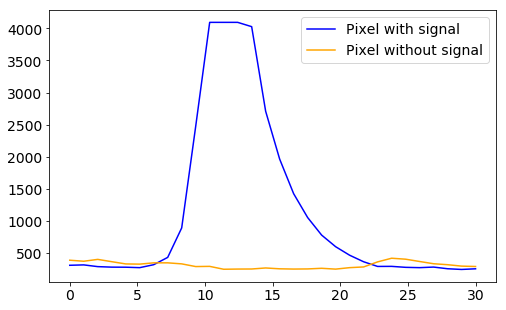

In [9]:
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 14
nsamples = data.shape[2]
sample = np.linspace(0,30,nsamples)
plt.plot(sample,data[0][pixelwithsignal],label="Pixel with signal",color =  "blue")
plt.plot(sample,data[0][0],label="Pixel without signal", color = "orange")
plt.legend()

## Calibration

**Get the pedestal, which is is the average (for pedestal events) of the *sum* of all samples, from sim_telarray**

In [10]:
ped = event.mc.tel[tel_id].pedestal
ped.shape

(2, 1855)

Each pixel has its pedestal for the two gains.

**Correct the pedestal (np.atleast_3d function converts 2D to 3D matrix)**

In [11]:
pedcorrectedsamples = data - np.atleast_3d(ped) / nsamples
pedcorrectedsamples.shape

(2, 1855, 30)

**We can now compare the corrected waveforms with the previous ones**

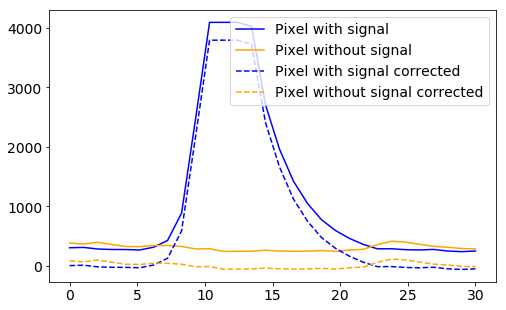

In [12]:
plt.plot(sample,data[0][pixelwithsignal],label="Pixel with signal",color="blue")
plt.plot(sample,data[0][0],label="Pixel without signal",color="orange")
plt.plot(sample,pedcorrectedsamples[0][pixelwithsignal],label="Pixel with signal corrected",color="blue",linestyle="--")
plt.plot(sample,pedcorrectedsamples[0][0],label="Pixel without signal corrected",color="orange",linestyle="--")
plt.legend()

## Integration

**We must now find the peak in the waveform and do the integration to extract the charge in the pixel**

In [13]:
from ctapipe.image.extractor import LocalPeakWindowSum

In [14]:
integrator = LocalPeakWindowSum()                                                                                                        
integration, peakpos = integrator(pedcorrectedsamples)

In [15]:
integration.shape, peakpos.shape, window.shape

((2, 1855), (2, 1855), (2, 1855, 30))

Integration gives the value of the charge

In [16]:
integration[0][0],integration[0][pixelwithsignal]

(320.4719, 18002.957)

Peakpos gives the position of the peak (in which sample it falls)

In [17]:
peakpos[0][0],peakpos[0][pixelwithsignal]

(23, 10)

window gives the number of samples used for the integration

In [18]:
window[0][0],window[0][pixelwithsignal]
sample[window[0][0]]

array([20.68965517, 21.72413793, 22.75862069, 23.79310345, 24.82758621,
       25.86206897, 26.89655172])

**We can plot these positions on top of the waveform and decide if the integration and peak identification has been correct**

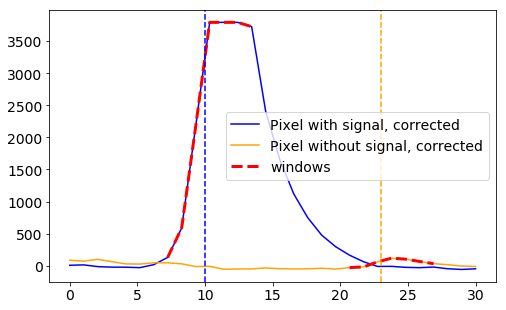

In [19]:
import matplotlib.patches as patches
plt.plot(sample,pedcorrectedsamples[0][pixelwithsignal],label="Pixel with signal, corrected",color="blue")
plt.plot(sample,pedcorrectedsamples[0][0],label="Pixel without signal, corrected",color="orange")
plt.plot(sample[window[0][0]],pedcorrectedsamples[0][0][window[0][0]],
         color="red",label="windows",linewidth=3,linestyle="--")
plt.plot(sample[window[0][pixelwithsignal]],pedcorrectedsamples[0][pixelwithsignal][window[0][pixelwithsignal]],
         color="red",linewidth=3,linestyle="--")
plt.axvline(peakpos[0][0],linestyle="--",color="orange")
plt.axvline(peakpos[0][pixelwithsignal],linestyle="--",color="blue")
plt.legend()

**Finally we must convert the charge from digital counts to photoelectrons multipying by the correlation factor**

In [20]:
signals = integration.astype(float) 
dc2pe = event.mc.tel[tel_id].dc_to_pe  # numgains * numpixels
signals *= dc2pe

**Choose the correct calibration factor for each pixel depending on its intensity. Very bright pixels saturates and the local peak integrator underestimates the intensity of the pixel.**

In [21]:
data[0]
combined = signals[0].copy() # On a basis we will use the high gain
for pixel in range(0,combined.size):
    if np.any(data[0][pixel] > 4094):
        print(signals[1][pixel],signals[0][pixel])
        combined[pixel] = signals[1][pixel]

154.2189825574569 106.71891315004723
108.62617564522589 97.2336895814351
141.91132172074958 102.77316036554839
91.97968342746208 89.68415524906595
100.32326871071928 98.0280144216008


**And fill the DL1 containers**

In [22]:
event.dl1.tel[tel_id].image = combined                                                                                                       
event.dl1.tel[tel_id].peakpos = peakpos
event.dl1.tel[tel_id]

ctapipe.io.containers.DL1CameraContainer:
                         image: np array of camera image, after waveform
                                integration (N_pix)
                  gain_channel: boolean numpy array of which gain channel was
                                used for each pixel in the image
             extracted_samples: numpy array of bools indicating which samples
                                were included in the charge extraction as a
                                result of the charge extractor chosen.
                                Shape=(nchan, npix, nsamples).
                       peakpos: numpy array containing position of the peak as
                                determined by the peak-finding algorithm for
                                each pixel
                       cleaned: numpy array containing the waveform after
                                cleaning

**Say hello to our shower!**

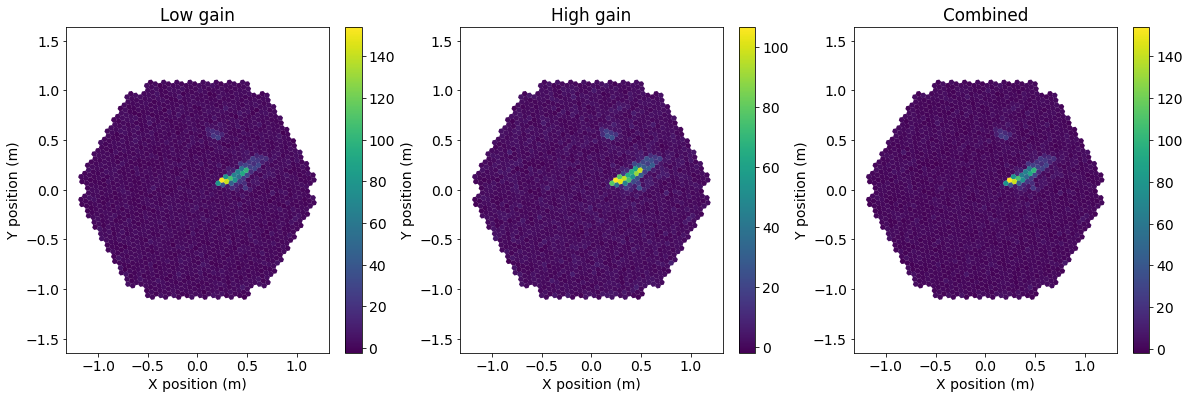

In [23]:
from ctapipe.visualization import CameraDisplay
camera = event.inst.subarray.tel[tel_id].camera
plt.rcParams['figure.figsize'] = (20, 6)
plt.rcParams['font.size'] = 14
plt.subplot(1,3,1)
disp = CameraDisplay(camera,title="Low gain")
disp.add_colorbar()
disp.image = signals[1]
plt.subplot(1,3,2)
disp = CameraDisplay(camera,title = "High gain")
disp.add_colorbar()
disp.image = signals[0]
plt.subplot(1,3,3)
disp = CameraDisplay(camera,title = "Combined")
disp.add_colorbar()
disp.image = combined

## Image cleaning

In [24]:
from ctapipe.image import hillas_parameters, tailcuts_clean
cleaning_method = tailcuts_clean
cleaning_parameters = {'boundary_thresh': 3,                                                                                                            
                       'picture_thresh': 6,                                                                                                             
                       'keep_isolated_pixels': False,                                                                                                   
                       'min_number_picture_neighbors': 1                                                                                                
                       }

In [25]:
signal = combined
signal_pixels = cleaning_method(camera,signal,**cleaning_parameters)

We use the combined image.

In [26]:
image = signal                                                                                                                          
image[~signal_pixels] = 0

**Let's take a look at the clean and shiny image**

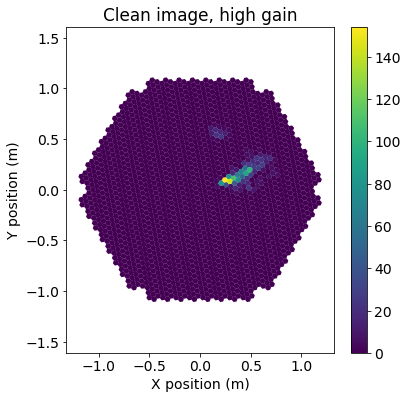

In [27]:
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['font.size'] = 14
disp = CameraDisplay(camera,title = "Clean image, high gain")
disp.image = image
disp.add_colorbar()

## Hillas parameters

First compute them:

In [28]:
hillas = hillas_parameters(camera, image)
hillas.intensity

1948.4154619338804

**And plot them over the image**

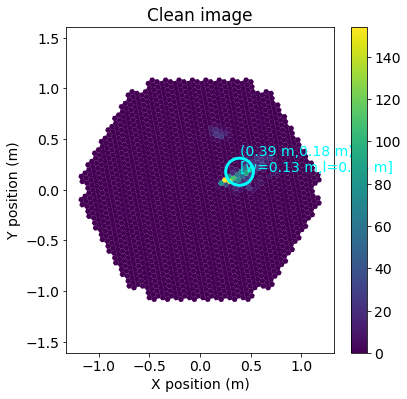

In [29]:
disp = CameraDisplay(camera,title = "Clean image")
disp.add_colorbar()
disp.image = image
disp.overlay_moments(hillas, color='cyan', linewidth=3)

**Also we can calculate the timing parameters**

In [30]:
from ctapipe.image import timing_parameters as time
timepars = time.timing_parameters(camera, image, peakpos[0], hillas)
timepars

ctapipe.io.containers.TimingParametersContainer:
                         slope: Slope of arrival times along main shower axis
                     intercept: intercept of arrival times along main shower
                                axis

In [31]:
timepars.slope,timepars.intercept

(<Quantity 5.59423921 1 / m>, 10.951732557768855)

## Reconstruction of disp

In [32]:
from lstchain.reco.utils import get_event_pos_in_camera, disp, disp_to_pos

In [33]:
tel = event.inst.subarray.tel[tel_id]

In [34]:
src_pos = get_event_pos_in_camera(event, tel)

d = disp(src_pos, hillas)
s = np.sign(src_pos[0] - hillas.x)
dx = src_pos[0] - hillas.x
dy = src_pos[1] - hillas.y

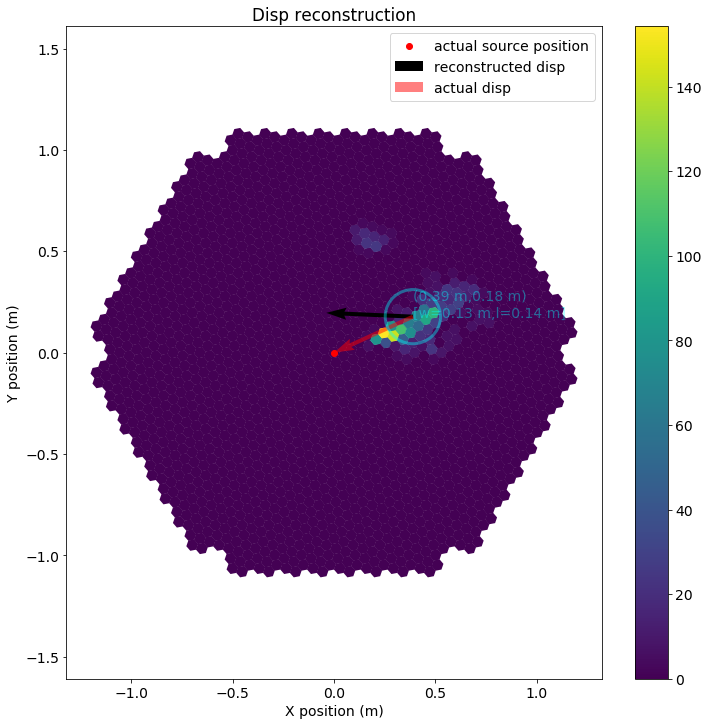

In [35]:
plt.figure(figsize=(12,12))
display = CameraDisplay(camera,title = "Disp reconstruction")
display.add_colorbar()
display.image = image
display.overlay_moments(hillas, color='cyan', linewidth=3, alpha=0.4)
plt.scatter(src_pos[0], src_pos[1], color='red', label='actual source position')
uu = s * d.value * np.cos(hillas.psi)
vv = s * d.value * np.sin(hillas.psi)
plt.quiver(hillas.x, hillas.y, uu, vv, units='xy', scale=1,
           label= "reconstructed disp",
          )

plt.quiver(hillas.x, hillas.y, dx.value, dy.value, 
           units='xy', scale=1,
           color='red',
           alpha=0.5,
           label= "actual disp", 
          )

plt.legend();

**In a real use case, the _disp_ value (length of the vector) is reconstructed by training a random forest.   
The _reconstructed disp_ above assumes a perfect length reconstruction.   
The direction of the `disp` vector is given by the ellipse direction (`hillas.psi`)**

## Lets compare the difference between high and low gain images for all events in the simtelarray file:

In [37]:
pyhessio.close_file()
intensity_high = np.array([])
intensity_low = np.array([])
nevents = 0
for event in source:
    if nevents%100==0:
        print(nevents)
    if nevents >= 500:
        break
    #if np.any(event.r0.tel[1].waveform > 4094):
    #    continue
    geom = event.inst.subarray.tel[tel_id].camera
    lst_calibration(event,tel_id)
    for Nphe_high, Nphe_low in zip(event.dl1.tel[tel_id].image[0],event.dl1.tel[tel_id].image[1]):
        if Nphe_high > 0 and Nphe_low > 0:
            intensity_high = np.append(Nphe_high,intensity_high)
            intensity_low = np.append(Nphe_low,intensity_low)
    nevents=nevents+1

0
100
200
300
400
500


0.003335214106012082 0.061168912254382875
-0.00015653264325069546 0.02898070091121532
0.05603075027676546 0.09083168135316513
1.1599672689070848 0.7336135113157438


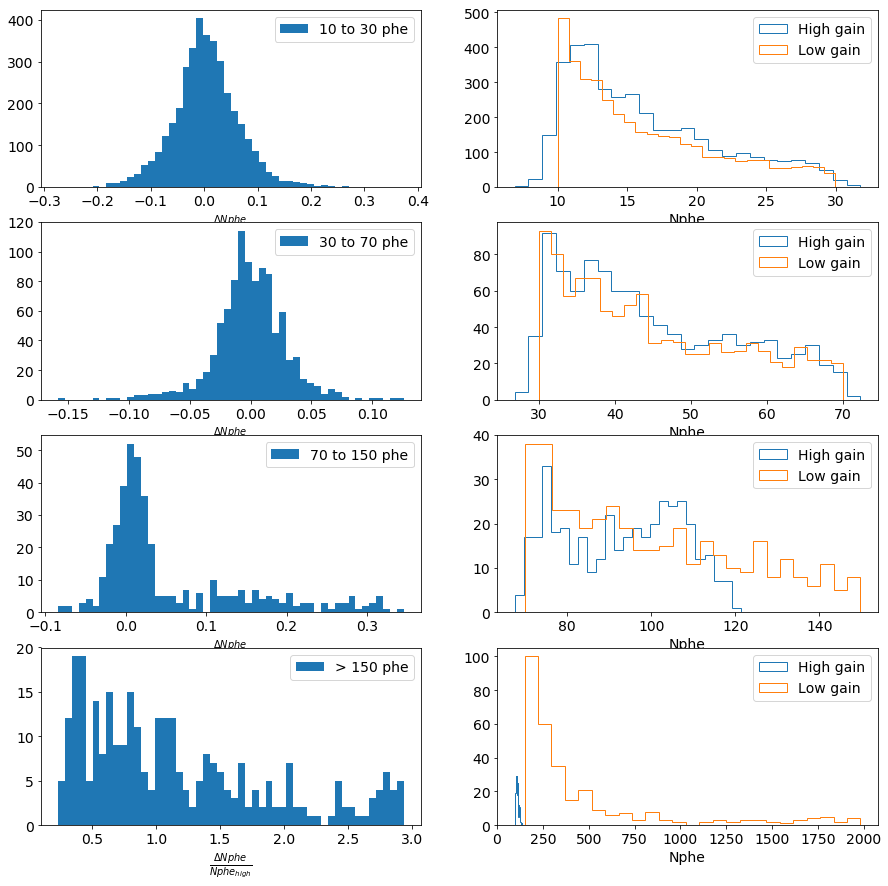

In [38]:
from scipy.stats import norm
plt.figure(figsize=(15,15))
#diff = (np.log10(intensity_low)-np.log10(intensity_high))*np.log(10)
pixels_df = pd.DataFrame(data ={'high_gain':intensity_high,
                                'low_gain':intensity_low,
                                'diff':np.log(intensity_low/intensity_high)})

pixels_df['Bin1'] = (pixels_df['low_gain'] >= 10) & (pixels_df['low_gain'] < 30) 
pixels_df['Bin2'] = (pixels_df['low_gain'] >= 30) & (pixels_df['low_gain'] < 70) 
pixels_df['Bin3'] = (pixels_df['low_gain'] >= 70) & (pixels_df['low_gain'] < 150)
pixels_df['Bin4'] = (pixels_df['low_gain'] >= 150)

plt.subplot(421)
h = plt.hist(pixels_df[pixels_df['Bin1']]['diff'],bins=50,label='10 to 30 phe')
plt.xlabel(r'$\frac{\Delta Nphe}{Nphe_{high}}$')
plt.legend()
plt.subplot(422)
h2 = plt.hist(pixels_df[pixels_df['Bin1']]['high_gain'],histtype=u'step',label = "High gain",bins=25)
h3 = plt.hist(pixels_df[pixels_df['Bin1']]['low_gain'],histtype=u'step',label = "Low gain",bins=25)
plt.xlabel('Nphe')
plt.legend()
mu,sigma = norm.fit(pixels_df[pixels_df['Bin1']]['diff'])
print(mu,sigma)
plt.subplot(423)
h = plt.hist(pixels_df[pixels_df['Bin2']]['diff'],bins=50,label='30 to 70 phe')
plt.xlabel(r'$\frac{\Delta Nphe}{Nphe_{high}}$')
plt.legend()
plt.subplot(424)
h2 = plt.hist(pixels_df[pixels_df['Bin2']]['high_gain'],histtype=u'step',label = "High gain",bins=25)
h3 = plt.hist(pixels_df[pixels_df['Bin2']]['low_gain'],histtype=u'step',label = "Low gain",bins=25)
plt.xlabel('Nphe')
plt.legend()
mu,sigma = norm.fit(pixels_df[pixels_df['Bin2']]['diff'])
print(mu,sigma)
plt.subplot(425)
h = plt.hist(pixels_df[pixels_df['Bin3']]['diff'],bins=50,label='70 to 150 phe')
plt.xlabel(r'$\frac{\Delta Nphe}{Nphe_{high}}$')
plt.legend()
plt.subplot(426)
h2 = plt.hist(pixels_df[pixels_df['Bin3']]['high_gain'],histtype=u'step',label = "High gain",bins=25)
h3 = plt.hist(pixels_df[pixels_df['Bin3']]['low_gain'],histtype=u'step',label = "Low gain",bins=25)
plt.xlabel('Nphe')
plt.legend()
mu,sigma = norm.fit(pixels_df[pixels_df['Bin3']]['diff'])
print(mu,sigma)
plt.subplot(427)
h = plt.hist(pixels_df[pixels_df['Bin4']]['diff'],bins=50,label='> 150 phe')
plt.xlabel(r'$\frac{\Delta Nphe}{Nphe_{high}}$')
plt.legend()
plt.subplot(428)
h2 = plt.hist(pixels_df[pixels_df['Bin4']]['high_gain'],histtype=u'step',label = "High gain",bins=25)
h3 = plt.hist(pixels_df[pixels_df['Bin4']]['low_gain'],histtype=u'step',label = "Low gain",bins=25)
plt.xlabel('Nphe')
plt.legend()
mu,sigma = norm.fit(pixels_df[pixels_df['Bin4']]['diff'])
print(mu,sigma)

## Use Pyhessio to access to extra MC data

In [57]:
pyhessio.close_file()
with pyhessio.open_hessio(input_filename) as ev:
    for event_id in ev.move_to_next_event():
        tels_with_data = ev.get_telescope_with_data_list()
        if event_id==EvID:
            print('run id {}:, event number: {}'.format(ev.get_run_number() , event_id))    
            print('    Triggered telescopes for this event: {}'.format(tels_with_data))
            nphe = np.sum(ev.get_mc_number_photon_electron(1))
            emin = ev.get_mc_E_range_Min()
            emax = ev.get_mc_E_range_Max()
            index = ev.get_spectral_index()
            cone = ev.get_mc_viewcone_Max()                                   
            core_max = ev.get_mc_core_range_Y()
            
            break

run id 8:, event number: 26107
    Triggered telescopes for this event: [ 1  2  3  4  5  6  7  8  9 10 16 17 18 23 45 46 47 48 49 50 51 52 53 54
 55 56 73 74 75 76 96 98 99]


In [58]:
print('Number of Phe: ',nphe)
print('Hillas intensity',hillas.intensity)

Number of Phe:  2511
Hillas intensity 1948.4154619338804


## Get the number of simulated events in the file(very slow)

In [59]:
#numevents = pyhessio.count_mc_generated_events(input_filename)
numevents = 1000000
print(numevents)

1000000


## Calculate the spectral weighting for the event

In [61]:
emin,emax,index,cone,core_max

(0.003000000026077032, 330.0, -2.0, 0.0, 1600.0)

In [62]:
particle = utils.guess_type(input_filename)
K = numevents*(1+index)/(emax**(1+index)-emin**(1+index))                    
A = np.pi*core_max**2
Omega = 2*np.pi*(1-np.cos(cone))
if cone==0:
    Omega=1
MeVtoGeV = 1e-3                                                     
if particle=="gamma":                                                
    K_w = 5.7e-16*MeVtoGeV                                           
    index_w = -2.48                                                  
    E0 = 0.3e6*MeVtoGeV                                              
                                                                         
if particle=="proton":                                               
    K_w = 9.6e-2                                                     
    index_w = -2.7                                                   
    E0 = 1                                                           
                                                                         
Simu_E0 = K*E0**index                                                
N_ = Simu_E0*(emax**(index_w+1)-emin**(index_w+1))/(E0**index_w)/(index_w+1)                                                                 
R = K_w*A*Omega*(emax**(index_w+1)-emin**(index_w+1))/(E0**index_w)/(index_w+1)

energy = event.mc.energy.value

w = ((energy)**(index_w-index))*R/N_

print('Spectral weight: ',w)

Spectral weight:  8.548736870275003e-09


## We can compare the Hillas intensity with the MC photoelectron size of the events to check the effects of cleaning

**Set the number of events that we want to analyze and the name of the output h5 file(None for using all events in the file)**

In [63]:
r0_to_dl1.max_events = None                           
output_filename = 'dl1_' + os.path.basename(input_filename).split('.')[0] + '.h5'

**Run lstchain to get dl1 events**

In [64]:
r0_to_dl1.r0_to_dl1(input_filename,output_filename)

0
100
200
300


/home/queenmab/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ctapipe-0.5.2.post535-py3.6-linux-x86_64.egg/ctapipe/image/hillas.py:563: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt((vy2 + vx2 - z) / 2.0)


400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800


**Use Pyhessio to obtain more MC info, like the number of MC photoelectrons in the camera**

In [67]:
mc_phe = np.array([])
id = np.array([])
counter=0
#Get MC info with pyhessio
with pyhessio.open_hessio(input_filename) as ev:
    for event_id in ev.move_to_next_event():
        tels_with_data = ev.get_telescope_with_data_list()
            
        if 1 in tels_with_data:
            counter=counter+1
            if counter==r0_to_dl1.max_events:
                break
            nphe = np.sum(ev.get_mc_number_photon_electron(1))
            emin = ev.get_mc_E_range_Min()
            emax = ev.get_mc_E_range_Max()
            index = ev.get_spectral_index()
            cone = ev.get_mc_viewcone_Max()                            
            core_max = ev.get_mc_core_range_Y()
            mc_phe = np.append(mc_phe,nphe)
            id = np.append(id,event_id)

**Use pandas to assign the info obtained with pyhessio to the corresponding dl1 previous events**

In [68]:
mc_df = pd.DataFrame()    
mc_df['mc_phe'] = mc_phe
mc_df['event_id'] = id.astype(int)
df_dl1 = pd.read_hdf(output_filename)
df_dl1 = df_dl1.set_index('event_id')
mc_df = mc_df.set_index('event_id').reindex(df_dl1.index)
df_dl1['mc_phe'] = np.log10(mc_df['mc_phe'])

**Plot the hillas intensity vs mc photoelectron size**

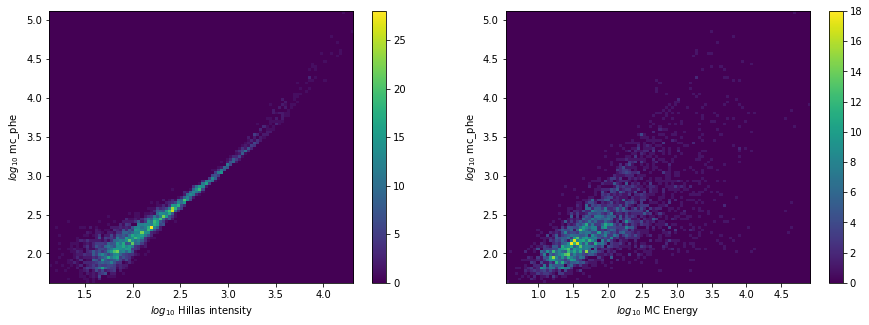

In [73]:
plt.figure(figsize=(15,5))
plt.subplot(121)
h = plt.hist2d(df_dl1[df_dl1['mc_phe']>0]['intensity'],df_dl1[df_dl1['mc_phe']>0]['mc_phe'],bins=100)
plt.xlabel('$log_{10}$ Hillas intensity')
plt.ylabel('$log_{10}$ mc_phe')
plt.colorbar(h[3])
plt.subplot(122)
h = plt.hist2d(df_dl1[df_dl1['mc_phe']>0]['mc_energy'],df_dl1[df_dl1['mc_phe']>0]['mc_phe'],bins=100)
plt.xlabel('$log_{10}$ MC Energy')
plt.ylabel('$log_{10}$ mc_phe')
plt.colorbar(h[3])

## Apply the spectral weighting for this set of events

In [74]:
df_dl1['w'] = ((10**df_dl1['mc_energy'])**(index_w-index))*R/N_

Text(0.5,0,'$log_{10}E (GeV)$')

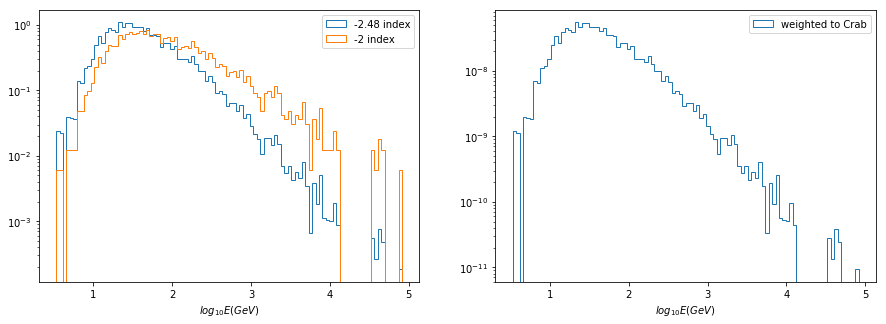

In [75]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(df_dl1['mc_energy'],histtype=u'step',bins=100,weights = df_dl1['w'],density=1,label="-2.48 index")
plt.hist(df_dl1['mc_energy'],histtype=u'step',bins=100,density=1,label="-2 index")
plt.yscale('log')
plt.xlabel("$log_{10}E (GeV)$")
plt.legend()
plt.subplot(122)
plt.hist(df_dl1['mc_energy'],histtype=u'step',bins=100,weights = df_dl1['w'],label="weighted to Crab")
plt.legend()
plt.yscale('log')
plt.xlabel("$log_{10}E (GeV)$")
#plt.xscale('log')